In [167]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier

# matplotlib  3.1.1
import matplotlib.pyplot as plt

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

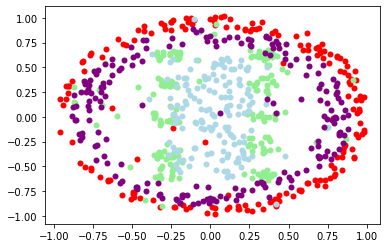

In [168]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X = X.astype(np.float)
y = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [169]:
df_test = pd.read_csv('./test.csv')
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1:]
y_test.iloc[:, 0] = y_test.iloc[:, 0].map(y_mapping)
X_train = pd.DataFrame(X, columns=df_test.columns.values[:-1])
y_train = pd.DataFrame(y, columns=df_test.columns.values[-1:])

# display(X_test.head())
# display(y_test.head())
# display(X_train.head())
# display(y_train.head())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Polynomial Features

Since the data points plotted above seems like circles, it may be seperated with the projection of X^2 + Y^2. 

In [170]:
poly = PolynomialFeatures(2)
X_train = pd.DataFrame(poly.fit_transform(X_train))
X_test = pd.DataFrame(poly.fit_transform(X_test))

# Class Tune & GridSearch

An utility class to fine-tune and save the models.

I use mean accuracy score of 5 fold cross validation to evaluation models.

In [171]:
from joblib import dump, load
import os
from sklearn.base import clone

parallel_procs = -1

class Tune():
  def __init__(self, model_dir="models/", result_dir="cvs/", is_load_saved=False, parallel_procs=-1):
    self.model_dir = model_dir
    self.result_dir = result_dir
    self.is_load_saved = is_load_saved
    self.parallel_procs = parallel_procs

    self.__global_best_score = 0
    self.__global_best_model = None
    self.__global_best_cv_results = None
    self.__global_best_model_name = 'None'

    # Make output directory
    if not os.path.exists(self.model_dir) : os.mkdir(self.model_dir)
    if not os.path.exists(self.result_dir) : os.mkdir(self.result_dir)

  def fit(self, X_train, y_train, clf, params, name, scoring=None, is_show=True):
    if(not self.is_load_saved):
        gs = GridSearchCV(clf, params, scoring=scoring, cv=5, n_jobs=parallel_procs, return_train_score=True)
        gs.fit(X_train, y_train)

        cv_results = pd.DataFrame(gs.cv_results_)
        best_score = gs.best_score_
        best_param = gs.best_params_
        best_model = clone(gs.best_estimator_)
        best_model.fit(X_train, y_train)
    else:
        best_model = load(f'{self.model_dir}{name}.joblib')
        cv_results = pd.read_csv(f'{self.result_dir}{name}-cv.csv', index_col=False)
        cv_results.drop(cv_results.columns[[0]], axis=1, inplace=True)
        best_param = best_model.get_params()
        
        score_sorted_idxs = np.argsort(cv_results[['mean_test_score']].values.ravel())[::-1]
#         print(score_sorted_idxs)
#         print(score_sorted_idxs[0])
        best_score = cv_results.loc[score_sorted_idxs[0], ['mean_test_score']].values[0]
        
    if(is_show):
        display(cv_results.drop(columns=['mean_fit_time',	
                                         'std_fit_time',	
                                         'mean_score_time',	
                                         'std_score_time',
                                         'split0_train_score', 
                                         'split1_train_score', 
                                         'split2_train_score', 
                                         'split3_train_score', 
                                         'split4_train_score']))
        print(f'Mean Validation Score of Best: {best_score}')
        print(f'Params of Best: {best_param}')
    
    self.record(best_model, best_score, cv_results, name)
    return best_model, best_score, best_param, cv_results

  def record(self, model, score, cv_results, name):
    print(f'Recording Model: {name}')
    
    if(self.__global_best_model == None and self.__global_best_score == 0):
        print(f'Init Best Model: {name}, CV: {score}')
        self.__global_best_score = score
        self.__global_best_model = model
        self.__global_best_cv_results = cv_results
        self.__global_best_model_name = name
        
        dump(model, f'{self.model_dir}{name}.joblib')
        dump(model, f'{self.model_dir}best.joblib')
        cv_results.to_csv(f'{self.result_dir}best-cv.csv')
        cv_results.to_csv(f'{self.result_dir}{name}-cv.csv')
        
    else:
        if(self.__global_best_score > score):
            print(f'Keep Best Model: {self.__global_best_model_name}, CV: {self.__global_best_score}')
            dump(model, f'{self.model_dir}{name}.joblib')
            cv_results.to_csv(f'{self.result_dir}{name}-cv.csv')
            
        else:
            print(f'Update Best Model: {name}, CV: {score}')
            self.__global_best_score = score
            self.__global_best_model = model
            self.__global_best_cv_results = cv_results
            self.__global_best_model_name = name
            
            dump(model, f'{self.model_dir}{name}.joblib')
            dump(model, f'{self.model_dir}best.joblib')
            cv_results.to_csv(f'{self.result_dir}best-cv.csv')
            cv_results.to_csv(f'{self.result_dir}{name}-cv.csv')
  # def load_best(self):
  #   return load(f'{self.model_dir}best.joblib')

  def best_model_acc(self, X, y):
    best = self.load_best_model()
    acc = accuracy_score(y, best.predict(X))
    # print(f'Training Acc')
    # print(f'{acc}')

    return acc

  def best_model_cv_score(self, X, y, cv=5):
    best = self.load_best_model()
    cv_score = cross_val_score(clone(best), X, y, cv=cv)
    mean = sum(cv_score) / len(cv_score)
    std = np.std(cv_score)

    # print(f'CV 5 folds Acc')
    # print(f'Mean {sum(cv_score) / len(cv_score)}')
    # print(f'{cv_score}')
    return cv_score, mean, std

  def best_model_predict(self, X_test):
    best = self.load_best_model()
    print(f'Best Model')
    print(f'{type(best).__name__}')
    # print(f'Parameters')
    # print(best.get_params())

    pred_best = pd.DataFrame(best.predict(X_test))
    pred_best.to_csv('models/best.csv', index=False, header=False)
    
    return pred_best

  def load_model(self, name):
    return load(f'{self.model_dir}{name}.joblib')

  def load_cv(self, name):
    return load(f'{self.result_dir}{name}.joblib')

  def load_best_model(self):
    return load(f'{self.model_dir}best.joblib')

  def load_best_cv(self):
    return pd.read_csv(f'{self.result_dir}best-cv.csv')

  def save_model(self, model, name):
    dump(model, f'{self.model_dir}{name}.joblib')

  def save_cv(self, cv_results, name):
    cv_results.to_csv(f'{self.result_dir}{name}-cv.csv')

tune = Tune(is_load_saved=False)

# SVC

In [172]:
params = [
          {
              'C': [1, 5, 10], 
              'kernel': ['rbf', 'sigmoid'], 
          },
          {
              'C': [1, 5, 10], 
              'kernel': ['poly'],
              'degree': [3, 5]
          }
]
model_svc, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), SVC(), params, 'svc')

,param_C,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,1,rbf,NaN,"{'C': 1, 'kernel': 'rbf'}",0.750000,0.858108,0.837838,0.809524,0.836735,0.818441,0.037545,9,0.832307,0.013496
1,1,sigmoid,NaN,"{'C': 1, 'kernel': 'sigmoid'}",0.418919,0.445946,0.378378,0.387755,0.448980,0.415996,0.029004,11,0.420389,0.022221
2,5,rbf,NaN,"{'C': 5, 'kernel': 'rbf'}",0.837838,0.891892,0.844595,0.843537,0.863946,0.856361,0.019829,3,0.867206,0.004817
3,5,sigmoid,NaN,"{'C': 5, 'kernel': 'sigmoid'}",0.479730,0.500000,0.391892,0.448980,0.476190,0.459358,0.037442,10,0.432591,0.025930
4,10,rbf,NaN,"{'C': 10, 'kernel': 'rbf'}",0.844595,0.878378,0.851351,0.836735,0.877551,0.857722,0.017165,2,0.868900,0.005162
5,10,sigmoid,NaN,"{'C': 10, 'kernel': 'sigmoid'}",0.439189,0.439189,0.331081,0.360544,0.442177,0.402436,0.047175,12,0.401085,0.025754
6,1,poly,3,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",0.810811,0.891892,0.817568,0.802721,0.836735,0.831945,0.032012,8,0.849592,0.005628
7,1,poly,5,"{'C': 1, 'degree': 5, 'kernel': 'poly'}",0.837838,0.878378,0.831081,0.802721,0.863946,0.842793,0.026386,7,0.856029,0.004823
8,5,poly,3,"{'C': 5, 'degree': 3, 'kernel': 'poly'}",0.817568,0.898649,0.851351,0.843537,0.877551,0.857731,0.028008,1,0.868222,0.004547
9,5,poly,5,"{'C': 5, 'degree': 5, 'kernel': 'poly'}",0.831081,0.871622,0.844595,0.829932,0.863946,0.848235,0.016949,6,0.870253,0.006108


Mean Validation Score of Best: 0.8577312005883435
Params of Best: {'C': 5, 'degree': 3, 'kernel': 'poly'}
Recording Model: svc
Init Best Model: svc, CV: 0.8577312005883435


# Decision Tree

I've tried stump decision tree model. The accuracy score of them are about 0.4. It is a reasonable result.

In [173]:
params = [{ 
              'criterion': ['entropy', 'gini'],
              'max_depth': [1, 5, 10, 20, 50, 100, None],
          }]

model_tree, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), DecisionTreeClassifier(), params, 'tree')

,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,entropy,1,"{'criterion': 'entropy', 'max_depth': 1}",0.439189,0.418919,0.378378,0.374150,0.435374,0.409202,0.027776,13,0.418021,0.005819
1,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.837838,0.770270,0.837838,0.741497,0.843537,0.806196,0.042127,1,0.875675,0.006621
2,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.777027,0.804054,0.858108,0.748299,0.802721,0.798042,0.036282,3,0.965447,0.006992
3,entropy,20,"{'criterion': 'entropy', 'max_depth': 20}",0.763514,0.770270,0.797297,0.721088,0.782313,0.766896,0.025625,12,1.000000,0.000000
4,entropy,50,"{'criterion': 'entropy', 'max_depth': 50}",0.756757,0.770270,0.824324,0.727891,0.789116,0.773672,0.032242,10,1.000000,0.000000
5,entropy,100,"{'criterion': 'entropy', 'max_depth': 100}",0.777027,0.770270,0.810811,0.734694,0.768707,0.772302,0.024235,11,1.000000,0.000000
6,entropy,None,"{'criterion': 'entropy', 'max_depth': None}",0.777027,0.783784,0.824324,0.727891,0.795918,0.781789,0.031434,7,1.000000,0.000000
7,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.439189,0.418919,0.378378,0.374150,0.435374,0.409202,0.027776,13,0.418359,0.006232
8,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.824324,0.729730,0.817568,0.782313,0.843537,0.799494,0.040113,2,0.883129,0.001894
9,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.797297,0.729730,0.844595,0.761905,0.782313,0.783168,0.038161,4,0.972223,0.004219


Mean Validation Score of Best: 0.8061959919102776
Params of Best: {'criterion': 'entropy', 'max_depth': 5}
Recording Model: tree
Keep Best Model: svc, CV: 0.8577312005883435


# Random Forest

In [174]:
params = [{
              'n_estimators': [100, 200, 400], 
              'criterion': ['entropy', 'gini'],
              'n_jobs': [parallel_procs]
          }]

model_forest, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), RandomForestClassifier(), params, 'forest')

,param_criterion,param_n_estimators,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,entropy,100,-1,"{'criterion': 'entropy', 'n_estimators': 100, ...",0.844595,0.864865,0.864865,0.836735,0.877551,0.857722,0.014886,2,1.000000,0.000000
1,entropy,200,-1,"{'criterion': 'entropy', 'n_estimators': 200, ...",0.851351,0.851351,0.864865,0.823129,0.891156,0.856371,0.022080,3,1.000000,0.000000
2,entropy,400,-1,"{'criterion': 'entropy', 'n_estimators': 400, ...",0.844595,0.864865,0.864865,0.829932,0.897959,0.860443,0.022929,1,1.000000,0.000000
3,gini,100,-1,"{'criterion': 'gini', 'n_estimators': 100, 'n_...",0.844595,0.810811,0.864865,0.816327,0.897959,0.846911,0.032163,6,0.999662,0.000677
4,gini,200,-1,"{'criterion': 'gini', 'n_estimators': 200, 'n_...",0.844595,0.824324,0.885135,0.829932,0.877551,0.852307,0.024731,5,1.000000,0.000000
5,gini,400,-1,"{'criterion': 'gini', 'n_estimators': 400, 'n_...",0.851351,0.817568,0.871622,0.823129,0.897959,0.852326,0.030054,4,1.000000,0.000000


Mean Validation Score of Best: 0.8604430961573819
Params of Best: {'criterion': 'entropy', 'n_estimators': 400, 'n_jobs': -1}
Recording Model: forest
Update Best Model: forest, CV: 0.8604430961573819


# KNN

In [175]:
# metric mahalanobis would casue singular matrix error, so drop it
params = [{
              'n_neighbors': [5, 100, 200, 500],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev', 'seuclidean'],
              'n_jobs': [parallel_procs]
         }]

model_knn, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), KNeighborsClassifier(), params, 'knn')

,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,minkowski,-1,5,uniform,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.824324,0.824324,0.844595,0.789116,0.863946,0.829261,0.024894,5,0.887532,0.005967
1,minkowski,-1,5,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.824324,0.844595,0.864865,0.816327,0.863946,0.842811,0.019897,1,1.000000,0.000000
2,minkowski,-1,100,uniform,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.466216,0.520270,0.486486,0.605442,0.482993,0.512282,0.049775,23,0.549451,0.017675
3,minkowski,-1,100,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.770270,0.858108,0.837838,0.775510,0.843537,0.817053,0.036697,11,1.000000,0.000000
4,minkowski,-1,200,uniform,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.290541,0.290541,0.270270,0.258503,0.272109,0.276393,0.012459,26,0.280835,0.025359
5,minkowski,-1,200,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.777027,0.844595,0.810811,0.782313,0.823129,0.807575,0.025275,13,1.000000,0.000000
6,minkowski,-1,500,uniform,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.270270,0.270270,0.270270,0.285714,0.272109,0.273727,0.006036,28,0.272697,0.000226
7,minkowski,-1,500,distance,"{'metric': 'minkowski', 'n_jobs': -1, 'n_neigh...",0.716216,0.729730,0.722973,0.714286,0.748299,0.726301,0.012271,19,1.000000,0.000000
8,euclidean,-1,5,uniform,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",0.824324,0.824324,0.844595,0.789116,0.863946,0.829261,0.024894,5,0.887532,0.005967
9,euclidean,-1,5,distance,"{'metric': 'euclidean', 'n_jobs': -1, 'n_neigh...",0.824324,0.844595,0.864865,0.816327,0.863946,0.842811,0.019897,1,1.000000,0.000000


Mean Validation Score of Best: 0.8428111785254643
Params of Best: {'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}
Recording Model: knn
Keep Best Model: forest, CV: 0.8604430961573819


# Voting Classifier

Here I clone and reuse the model that we got before. 

Since I've fine-tuned each kind of model(KNN, Decision Tree, Random Forest) to achieve the best score, I would clone and retrain them. Then, apply them to the VotingClassifier. The performance of the VotingClassifier is better than any other models before.

In [176]:
vc = VotingClassifier(estimators=[('knn', clone(model_knn)), 
                                  ('tree', clone(model_tree)), 
                                  ('forest', clone(model_forest))])
params = [{   
              'estimators': [[('knn', clone(model_knn)), ('tree', clone(model_tree)), ('forest', clone(model_forest))]],
              'weights': [[1, 2, 3], [2, 1, 3], [2.5, 1, 3.5], [2.7, 1, 3.7], [3, 1, 4], [3, 1.5, 4], [4, 1, 5], [4, 2, 5]],
              'voting': ['soft'],
              'n_jobs': [parallel_procs]
          },
          { 
              'estimators': [[('knn', clone(model_knn)), ('tree', clone(model_tree)), ('forest', clone(model_forest)), ('forest', clone(model_forest))]],  
              'voting': ['hard'],
              'n_jobs': [parallel_procs]
          }]
model, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), vc, params, 'vc')

# list(itertools.permutations(range(0,4)))

,param_estimators,param_n_jobs,param_voting,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[1, 2, 3]","{'estimators': [('knn', KNeighborsClassifier(a...",0.878378,0.824324,0.844595,0.843537,0.870748,0.852317,0.019694,8,0.994918,0.001859
1,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[2, 1, 3]","{'estimators': [('knn', KNeighborsClassifier(a...",0.864865,0.864865,0.871622,0.850340,0.884354,0.867209,0.011036,2,1.000000,0.000000
2,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[2.5, 1, 3.5]","{'estimators': [('knn', KNeighborsClassifier(a...",0.864865,0.844595,0.871622,0.843537,0.891156,0.863155,0.017821,6,1.000000,0.000000
3,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[2.7, 1, 3.7]","{'estimators': [('knn', KNeighborsClassifier(a...",0.864865,0.864865,0.871622,0.836735,0.891156,0.865849,0.017455,5,1.000000,0.000000
4,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[3, 1, 4]","{'estimators': [('knn', KNeighborsClassifier(a...",0.864865,0.864865,0.871622,0.843537,0.891156,0.867209,0.015260,1,1.000000,0.000000
5,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[3, 1.5, 4]","{'estimators': [('knn', KNeighborsClassifier(a...",0.864865,0.864865,0.871622,0.850340,0.884354,0.867209,0.011036,2,1.000000,0.000000
6,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[4, 1, 5]","{'estimators': [('knn', KNeighborsClassifier(a...",0.864865,0.851351,0.864865,0.843537,0.891156,0.863155,0.016212,6,1.000000,0.000000
7,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,soft,"[4, 2, 5]","{'estimators': [('knn', KNeighborsClassifier(a...",0.858108,0.858108,0.871622,0.850340,0.891156,0.865867,0.014382,4,1.000000,0.000000
8,"[(knn, KNeighborsClassifier(algorithm='auto', ...",-1,hard,NaN,"{'estimators': [('knn', KNeighborsClassifier(a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN


Mean Validation Score of Best: 0.8672090457804744
Params of Best: {'estimators': [('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='distance')), ('tree', DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')), ('forest', RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_imp

# Bagging Classifier

It increses the accuracy score in 5%. It's very incredible.

In [177]:
params = [{   
              'base_estimator': [clone(model_tree), clone(model_svc)],
              'n_estimators': [200, 500],
              'max_samples': [0.5, 0.7, 1.0],
              'max_features': [0.5, 0.7, 1.0],
              'random_state': [1],
              'n_jobs': [parallel_procs]
         }]
model, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), BaggingClassifier(), params, 'bag')

,param_base_estimator,param_max_features,param_max_samples,param_n_estimators,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.5,0.5,200,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.817568,0.864865,0.829932,0.863946,0.846884,0.019428,18,0.888208,0.005201
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.5,0.5,500,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.864865,0.810811,0.864865,0.836735,0.863946,0.848244,0.021600,16,0.889227,0.005119
2,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.5,0.7,200,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.817568,0.864865,0.836735,0.884354,0.852326,0.023098,11,0.890920,0.007019
3,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.5,0.7,500,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.810811,0.864865,0.836735,0.870748,0.848253,0.021971,15,0.892276,0.005529
4,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.5,1,200,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.817568,0.858108,0.836735,0.877551,0.849614,0.020580,13,0.892615,0.005926
5,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.5,1,500,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.810811,0.851351,0.829932,0.877551,0.845551,0.023092,20,0.892953,0.007071
6,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.7,0.5,200,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.810811,0.858108,0.823129,0.863946,0.842820,0.021569,25,0.888887,0.003856
7,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.7,0.5,500,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.871622,0.810811,0.864865,0.823129,0.863946,0.846874,0.024867,19,0.886177,0.004518
8,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.7,0.7,200,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.858108,0.810811,0.858108,0.829932,0.877551,0.846902,0.023584,17,0.892613,0.004657
9,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.7,0.7,500,-1,1,{'base_estimator': DecisionTreeClassifier(ccp_...,0.864865,0.797297,0.858108,0.836735,0.863946,0.844190,0.025558,22,0.891937,0.005716


Mean Validation Score of Best: 0.8590825519396947
Params of Best: {'base_estimator': SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 1}
Recording Model: bag
Keep Best Model: vc, CV: 0.8672090457804744


# AdaBoost Classifier

It gives a good improvement for Decision Tree model, although it doesn't imporve SVC so much.

In [178]:
# ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
params = [{   
              'base_estimator': [DecisionTreeClassifier(criterion='entropy', max_depth=1),
                                 DecisionTreeClassifier(criterion='entropy'), 
                                 clone(model_tree), 
                                 clone(model_svc)],
              'n_estimators': [200, 500],
              'learning_rate': [1, 0.1, 0.01],
              'algorithm': ['SAMME', 'SAMME.R']
         }]
model, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), AdaBoostClassifier(), params, 'ada')

,param_algorithm,param_base_estimator,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1,200,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.668919,0.722973,0.783784,0.741497,0.693878,0.722210,0.039513,25,0.753708,0.036817
1,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1,500,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.682432,0.675676,0.804054,0.768707,0.673469,0.720868,0.054726,26,0.740501,0.026666
2,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.1,200,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.466216,0.587838,0.567568,0.585034,0.598639,0.561059,0.048460,34,0.587372,0.055469
3,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.1,500,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.513514,0.736486,0.783784,0.714286,0.687075,0.687029,0.092367,27,0.719140,0.079987
4,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.01,200,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.472973,0.466216,0.412162,0.401361,0.462585,0.443059,0.030019,40,0.459013,0.008604
5,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.01,500,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.290541,0.317568,0.412162,0.394558,0.469388,0.376843,0.064942,42,0.404776,0.070352
6,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1,200,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.777027,0.756757,0.817568,0.721088,0.775510,0.769590,0.031335,18,1.000000,0.000000
7,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",1,500,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.750000,0.763514,0.810811,0.727891,0.768707,0.764185,0.027252,24,1.000000,0.000000
8,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.1,200,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.777027,0.750000,0.824324,0.721088,0.795918,0.773672,0.035769,14,1.000000,0.000000
9,SAMME,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.1,500,"{'algorithm': 'SAMME', 'base_estimator': Decis...",0.770270,0.756757,0.817568,0.721088,0.768707,0.766878,0.030930,23,1.000000,0.000000


Mean Validation Score of Best: 0.8618312189740761
Params of Best: {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 1, 'n_estimators': 500}
Recording Model: ada
Keep Best Model: vc, CV: 0.8672090457804744


# Stump Decision Tree with/without AdaBoost

It's also amazing that AdaBoost imporve the the stump decision tree model in about 20%. However, for deepeer decision tree, random forest give a better performance. The deeper the tree is, the less improvement AdaBoost gives.

In [179]:
# AdaBoost with Decision Tree
params = [{   
              'base_estimator': [DecisionTreeClassifier()],
              'base_estimator__max_depth': [1, 5, 10, 20, 50, 100, None],
              'n_estimators': [200],
         }]
model, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), AdaBoostClassifier(), params, 'ada_dt_test', is_show=False)
print('Mean Test Score of AdaBoost with Decision Tree as Base Estimator')
display(cv_results.loc[:, ['param_n_estimators', 'param_base_estimator__max_depth', 'mean_test_score']])

# Random Forest
params = [{   
              'max_depth': [1, 5, 10, 20, 50, 100, None],
              'n_estimators': [200],
              'n_jobs': [parallel_procs]
         }]
model, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), RandomForestClassifier(), params, 'forest_test', is_show=False)
print('Mean Test Score of Random Forest')
display(cv_results.loc[:, ['param_n_estimators', 'param_max_depth', 'mean_test_score']])

# Decision Tree
params = [{ 
              'max_depth': [1, 5, 10, 20, 50, 100, None],
          }]

model_tree, score, param, cv_results = tune.fit(X_train.values, y_train.values.ravel(), DecisionTreeClassifier(), params, 'tree_test', is_show=False)
print('Mean Test Score of Decision Tree')
display(cv_results.loc[:, ['param_max_depth', 'mean_test_score']])

Recording Model: ada_dt_test
Keep Best Model: vc, CV: 0.8672090457804744
Mean Test Score of AdaBoost with Decision Tree as Base Estimator


,param_n_estimators,param_base_estimator__max_depth,mean_test_score
0,200,1,0.638178
1,200,5,0.850965
2,200,10,0.856398
3,200,20,0.783186
4,200,50,0.779114
5,200,100,0.777772
6,200,None,0.776439


Recording Model: forest_test
Keep Best Model: vc, CV: 0.8672090457804744
Mean Test Score of Random Forest


,param_n_estimators,param_max_depth,mean_test_score
0,200,1,0.562374
1,200,5,0.842830
2,200,10,0.860452
3,200,20,0.855001
4,200,50,0.852344
5,200,100,0.859101
6,200,None,0.852317


Recording Model: tree_test
Keep Best Model: vc, CV: 0.8672090457804744
Mean Test Score of Decision Tree


,param_max_depth,mean_test_score
0,1,0.409202
1,5,0.799485
2,10,0.773699
3,20,0.788638
4,50,0.780502
5,100,0.780511
6,None,0.789998


# Select The Best Model

Here I finally choose Voting Classifier as the best model according to the validation result. 

In [180]:
y_pred = tune.best_model_predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"{type(tune.load_best_model()).__name__} Test Acc: {acc}")

Best Model
VotingClassifier
VotingClassifier Test Acc: 0.827027027027027
